In [71]:
# import all the libraries for the project
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from collections import defaultdict
from scipy import interp
import numpy as np
import itertools
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import plotly
import plotly.plotly as py
from plotly.plotly import plot, iplot
import plotly.graph_objs as go
import warnings
from collections import Counter
import math
from scipy.cluster import hierarchy as hc
import scipy.spatial as scs
import scipy.stats as ss
import plotly.figure_factory as ff

plotly.tools.set_credentials_file(username='albertobenincasa', api_key='14CCI1wSA0JGaDZhuouL')
warnings.filterwarnings("ignore")

In [69]:
# costanti
PLOTLY_COLORS = ['#4A708B', '#87CEFA']
PLOTLY_OPACITY = 0.7
COLORSCALE_HEATMAP = [         [0.0, ''], #BFEFFF #B0E2FF #87CEFF 
                [0.1111111111111111, ''], 
                [0.2222222222222222, ''], 
                [0.3333333333333333, ''], 
                [0.4444444444444444, ''], 
                [0.5555555555555556, ''], 
                [0.6666666666666666, ''], 
                [0.7777777777777778, ''], 
                [0.8888888888888888, ''], 
                               [1.0, '']]
COLOR_PALETTE = ['#140DFF', '#FF0DE2', '#CAFFD0', '#C9E4E7', '#B4A0E5', '#904C77']#= sns.color_palette("Blues") 

### INTRODUZIONE

Il dataset oggetto di questa analisi, visualizzabile e scaricabile all'indirizzo https://www.kaggle.com/ronitf/heart-disease-uci, consta di una serie di parametri di paziente affetti o no da disturbi di tipo cardiaco; esso deriva da un database contenente in origine 76 attributi, ma tutti le analisi effettuate si riferiscono ad un sottoinsieme di essi di 14 attributi.

Scendendo più nel dettaglio, apprendiamo che questi 14 attributi specificano diverse caratteristice, di seguito elencate:
* age : età del paziente in anni
* sex : sesso del paziente (1=maschio, 0=femmina)
* cp : tipologia di dolore addominale riscontrata (1=Angina pectoris tipica, 2=Angina pectoris atipica, 3=Dolore non dovuto ad Angina pectoris , 4=Asintomatico)
* trestbps : pressione del sangue a riposo del paziente (in mmHg all'ammissione in ospedale)
* chol : colesterolo del paziente misurato in mg/dl
* fbs : glicemia a digiuno > 120 mg/dl (1=vero; 0=falso) 
* restecg : risutati elettrocardiografici a riposo (0=normale, 1=presenza di anormalità nell'onda ST-T, 2=probabile ipertrofia ventricolo sinistro)  
* thalach : battito cardiaco massimo raggiunto
* exang : angina pectoris indotta da esercizio (1=si, 0=no) 
* oldpeak : sottoslivellamento del tratto ST indotta dall'esercizio, non presente a riposo
* slope : la pendenza durante il picco di esercizio del tratto ST
* ca : numero di vasi maggiori (0-3) colorati per fluoroscopia
* thal : malattia del sangue chiamata talassemia (3 = normale; 6 = difetto fisso; 7 = difetto reversibile)
* target : presenza di malattia (1=si, 0=no)

### CARICAMENTO DEL DATASET E ANALIZI PRELIMINARI

Come prima cosa carichiamo il dataset in una variabile di tipo DataFrame.

In [4]:
# Carico il dataset presente in locale
dataset = pd.read_csv("./dataset/heart.csv")

Il passo successivo consiste nel guardare il dataset appena caricato in modo da capirne il contenuto, le diverse feature disponibili e il tipo di dato presente in quest'ultime.

In [11]:
# Dimensione del dataset
print("Il dataset ha %d record e %d features.\n" % dataset.shape)

# Conteggio del numero di classi per la classificazione
print(f"Ci sono {dataset['target'].unique().size} classi differenti:"f"\n {dataset['target'].unique().tolist()}")

# Conteggio del numero di valori unici per ogni colonna
print(f"\nValori unici per ogni campo: \n{dataset.nunique()}")

Il dataset ha 303 record e 14 features.

Ci sono 2 classi differenti:
 [1, 0]

Valori unici per ogni campo: 
age          41
sex           2
cp            4
trestbps     49
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            5
thal          4
target        2
dtype: int64


### PREPROCESSING

Prima di poter passare alla classificazione, è fondamentale una fase di preprocessing dei dati. 
Questo è lo step più importante di tutti, perchè "pulire" i dati prima di "mandarli in pasto" ai diversi algoritmi di classificazione ha un duplice vantaggio: per prima cosa, evitiamo di sovraccaricare la potenza di calcolo della macchina per conti non utili alla classificazione finale, e per seconda, analizzare i dati prima di processarli ci permette di ottenere la classificazione migliore possibile.

Molto utile anche controllare la presenza di eventuali valori nulli: nel caso in cui ci fossero colonne non valorizzate, è bene procedere con l'eliminazione di quest'ultime per ridurre il numero di dati su cui dobbiamo lavorare.

Come possiamo notare, non vi è traccia della presenza di valori nulli nel dataset. 
La strategia alternativa all'eliminazione di intere colonne, particolarmente vantaggiosa solo se tutti i valori (o perlomeno, la maggior parte) sono non definiti è quella di inserire valori di default (come 0) per i record che non hanno valori definiti.

In [5]:
# Controllo la presenza di valori nulli
print(f"\nConteggio dei valori NaN: \n{dataset.isnull().sum()}")


Conteggio dei valori NaN: 
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


La prima, semplice, analisi da fare è quella di vedere che tipo di dati abbiamo.

In [4]:
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Come possiamo notare, tutti i nostri attributi sono di tipo numerico. Nonostante questo, dalla descrizione del dataset sappiamo che alcuni di questi valori corrispondono in realtà ad elementi di tipo categorico. 

Infatti, i campi valorizzati con delle stringhe non permettono un'analisi semplice, 
bla
bla
bla

Vediamo ora come i nostri campioni sono suddivisi nelle diverse classi

In [6]:
y = dataset['target'].value_counts()
print(y)

1    165
0    138
Name: target, dtype: int64


Fortunatamente, il dataset è abbastanza bilanciato: abbiamo circa lo stesso numero di campioni classificati come malati e non malati. Questo è molto importante perchè possiamo assegnare lo stesso peso alle due classi quando passeremo alla fase di classificazione.

Inoltre, possiamo notare come il nostro compito di classificazione sarà di tipo binario: infatti, il nostro obiettivo è riuscire a predire se un paziente potrebbe riscontrare malattie cardiache oppure no. Possiamo ora approfondire alcuni dettagli statistici sul dataset utilizzando il metodo **describe()** sul nostro DataFrame di pandas. L'output mostrerà:
* **count** -> specifica il numero dei record presenti nel dataset 
* **mean** -> specifica la media dell'attributo calcolata per tutti i record
* **std** -> specifica la deviazione standard dell'attributo
* **min** -> specifica il valore minimo dell'attributo
* **25%** -> il 25% dei record ha un valore minore di quello visualizzato (lower percentile)
* **50%** -> il 50% dei record ha un valore minore di quello visualizzato (median percentile)
* **75%** -> il 75% dei record ha un valore minore di quello visualizzato (upper percentile)
* **max** -> specifica il valore massimo dell'attributo

In [7]:
dataset.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [25]:
def create_bar(type, data, col, visible=False):
    if type == "sick":
        c = PLOTLY_COLORS[0]
    else:
        c = PLOTLY_COLORS[1]
    
    return go.Histogram(
        x = data[col],
        name = type,
        marker = dict(color = c),
        visible = visible,
        opacity = PLOTLY_OPACITY,
    )

def feature_histogram(data, feature, title):
    
    trace1 = create_bar("sick", data[data['target'] == 1], feature, True)
    trace2 = create_bar("healthy", data[data['target'] == 0], feature, True)
    
    data = [trace1, trace2]
    
    layout = dict(
        title=title,
        autosize=True,
        yaxis=dict(
            title='value',
            automargin=True,
        ),
        legend=dict(
            x=0,
            y=1,
        ),
        barmode='group',
        bargap=0.15,
        bargroupgap=0.1
    )
    fig = dict(data=data, layout=layout)

    return py.iplot(fig, filename=title)

feature_histogram(dataset, 'target', 'Distribuzione classi')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~albertobenincasa/0 or inside your plot.ly account where it is named 'Distribuzione classi'


A questo punto possiamo analizzare la distribuzione dei nostri dati usando dei boxplot: un boxplot è un modo standardizzato per visualizzare la distribuzione dei dati sulla base di un riepilogo di cinque numeri (min, lower percentile, median, upper percentile, max); risulta molto utile per visualizzare dati anomali e per controllare se i dati sono ditribuiti in modo simmetrico, quanto sono aggregati.

Le informazioni che possiamo ricavare da un box plot sono:
* **median**(Q2 / 50esimo percentile): il valore medio del dataset
* **first quartile**(Q1 / 25esimo percentile): il valore medio tra il valore più piccolo (non il minimo) e il median del dataset
* **third quartile**(Q3 / 75esimo percentile): il valore medio tra il valore più grande (non il massimo) e il median del dataset
* **interquartile range**(IQR): dal 25esimo al 75esimo percentile
* **outliers**: elementi visualizzati come singoli punti
* **maximum**: Q3 + 1.5xIQR
* **minimum**: Q1 - 1.5xIQR

Chiaramente, ha poco senso visualizzare in questo tipo di grafici quegli attributi che sono binari o che presentano poche opzioni, per cui filtreremo questi dati prima di visualizzare i grafici.

In [23]:
def create_box(type, data, col, visible=False):
    if type == 'sick':
        c = PLOTLY_COLORS[0]
    else:
        c = PLOTLY_COLORS[1]
        
    return go.Box(
        y = data[col],
        name = type,
        marker = dict(color = c),
        visible = visible,
        opacity = PLOTLY_OPACITY,
    )

sicks = dataset[dataset['target'] == 1]
healthy = dataset[dataset['target'] == 0]
box_features = [col for col in dataset.columns if ((col != 'class') and (dataset[col].nunique() > 5))]

active_index = 0

box_sick = [(create_box('sick', sicks, col, False) if i != active_index
           else create_box('sick', sicks, col, True))
             for i, col in enumerate(box_features)
            ]
box_healthy = [(create_box('healthy', healthy, col, False) if i != active_index
            else create_box('healthy', healthy, col, True))
             for i, col in enumerate(box_features)
            ]

#box_sick = []
#box_healthy = []
#for i, col in enumerate(box_features):
#    if i != active_index:
#        trace1 = create_box('sick', sicks, col, False)
#        trace2 = create_box('healthy', healthy, col, False)
#    else:
#        trace1 = create_box('sick', sicks, col, True)
#        trace2 = create_box('healthy', healthy, col, True)
#    
#    box_sick.append(trace1)
#    box_healthy.append(trace2)

data = box_sick + box_healthy
number_of_features = len(box_features)
steps = []

for i in range(number_of_features):
    step = dict(
        method = 'restyle',  
        args = ['visible', [False] * number_of_features],
        label = box_features[i],
    )
    step['args'][1][i] = True # Toggle i'th trace to "visible"
    #step['args'][1][i + number_of_features] = True # Toggle i'th trace to "visible"
    steps.append(step)
    
sliders = [dict(
    active = active_index,
    currentvalue = dict(
        prefix = "Feature: ", 
        xanchor= 'center',
    ),
    pad = {"t": 50},
    steps = steps,
    len=1,
)]

layout = dict(
    sliders=sliders,
    autosize=True,
    yaxis=dict(
        title='valori',
        automargin=True,
    ),
    legend=dict(
        x=0,
        y=1,
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='box_slider')

commenti sul grafico sopra

introduzione agli istrogrammi di sotto

In [28]:
hist_features = [col for col in dataset.columns if (col != 'target')]

active_index = 0
hist_sick = [(create_bar('sick', sicks, col, False) if i != active_index
           else create_bar('sick', sicks, col, True))
             for i, col in enumerate(hist_features)
            ]
hist_healthy = [(create_bar('healthy', healthy, col, False) if i != active_index
           else create_bar('healthy', healthy, col, True))
             for i, col in enumerate(hist_features)
            ]

total_data = hist_sick + hist_healthy
number_of_features = len(hist_features)
steps = []

for i in range(number_of_features):
    step = dict(
        method = 'restyle',
        args = ['visible', [False] * number_of_features],
        label = hist_features[i],
    )
    step['args'][1][i] = True
    steps.append(step)
    
sliders = [dict(
    active = active_index,
    currentvalue = dict(
        prefix = "Feature: ", 
        xanchor= 'center',
    ),
    pad = {"t": 50},
    steps = steps,
    len=1,
)]

layout = dict(
    sliders=sliders,
    autosize=True,
    yaxis=dict(
        title='valori',
        automargin=True,
    ),
    legend=dict(
        x=0,
        y=1,
    ),
)

fig = dict(data=total_data, layout=layout)
py.iplot(fig, filename='bar_slider')

commenti sui grafici sopra

Una matrice di correlazione è una tabella che mostra i coefficienti di correlazione tra insiemi di variabili. 
Ogni variabile casuale ($X_i$) nella tabella è correlata con ciascuno degli altri valori nella tabella ($X_j$); questo permette di vedere quali coppie hanno la più alta correlazione.
La correlazione si riferisce a qualsiasi associazione statistica, ma nell'uso comune del termine si indica quanto due variabili siano vicine ad avere una relazione lineare l'una con l'altra.

In questo frangente useremo la correlazione di Pearson, che è una misura della correlazione lineare tra due variabili $X$ e $Y$. Secondo la diseguaglianza di Cauchy-Schwartz, tale valore è compreso tra +1 e -1, dove +1 è la correlazione positiva totale, 0 è nessuna correlazione lineare e -1 è una correlazione negativa totale.

Questo coefficiente è calcolato come $ \frac{cov(X, Y)}{\sigma_X\sigma_Y} $ dove:
* $cov$ si chiama covarianza ed è calcolata come ($\mu$ è il valore medio)  $$ cov(X, Y) = E[(X - \mu_X)(Y - \mu_Y)] $$
* $\sigma_X$ è la deviazione standard di $X$ $$ \sigma_X = \sqrt{E[X^2] - (E[X])^2} $$
* $\sigma_Y$ è la deviazione standard di $Y$ $$ \sigma_Y = \sqrt{E[Y^2] - (E[Y])^2} $$

In [54]:
def plot_correlation_matrix(matrix, title):

    z_text = np.around(matrix.values.tolist(), decimals=2)

    figure = ff.create_annotated_heatmap(z=matrix.values, 
                                         x=matrix.columns.tolist(), 
                                         y=matrix.index.tolist(),
                                         annotation_text=z_text,
                                         colorscale='Blues',
                                         showscale=True)

    figure.layout.title = title
    figure.layout.autosize = False
    figure.layout.width = 850
    figure.layout.height = 850
    figure.layout.margin = go.layout.Margin(l=140, r=100, b=200, t=80)
    figure.layout.xaxis.update(side='bottom')
    figure.layout.yaxis.update(side='left')

    for i in range(len(figure.layout.annotations)):
        figure.layout.annotations[i].font.size = 8
                                    
    return py.iplot(figure, filename=title)

def plot_correlation_row(matrix, title):
    
    matrix = pd.Series.to_frame(matrix.loc['class']).transpose()
    z_text = np.around(matrix.values.tolist(), decimals=2)

    figure = ff.create_annotated_heatmap(z=matrix.values, 
                                         x=matrix.columns.tolist(), 
                                         y=matrix.index.tolist(),
                                         annotation_text=z_text,
                                         colorscale='Blues',
                                         showscale=False)

    figure.layout.title = title
    figure.layout.autosize = False
    figure.layout.width = 850
    figure.layout.height = 220
    figure.layout.xaxis.update(side='bottom')
    figure.layout.yaxis.update(side='left')

    for i in range(len(figure.layout.annotations)):
        figure.layout.annotations[i].font.size = 8


    return py.iplot(figure, filename=title)


In [55]:
corr_dataset = dataset.corr(method='pearson')
plot_correlation_matrix(corr_dataset, 'Matrice di correlazione')

In [56]:
def conditional_entropy(x, y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x, y):
    s_xy = conditional_entropy(x, y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

def create_theil_matrix(data):

    columns = data.columns
    matrix = []
    for col in columns:
        row = []
        for j in range(0, len(columns)):
            u = np.around(theil_u(data[col].tolist(), data[columns[j]].tolist()), decimals=4)
            row.append(u)
        matrix.append(row)
    
    matrix = np.array(matrix)

    matrix = pd.DataFrame(data=matrix,
                 columns=columns,
                 index=columns)
    return matrix


In [57]:
corr_dataset = create_theil_matrix(dataset)
plot_correlation_matrix(corr_dataset, "Theil_u correlation matrix")

In [59]:
feature_histogram(dataset, 'chol', 'distribuzione chol')

In [73]:
names = dataset.columns
inverse_correlation = 1 - corr_dataset # This is the 'dissimilarity' method

fig = ff.create_dendrogram(inverse_correlation, 
                           labels=names, 
                           colorscale=COLOR_PALETTE, 
                           linkagefun=lambda x: hc.linkage(x, 'average'))

fig['layout'].update(dict(
    title="Dendrogram of correlation among features",
    width=800, 
    height=600,
    xaxis=dict(
        title='Features',
    ),
    yaxis=dict(
        title='Distance',
    ),
))
iplot(fig, filename='dendrogram_corr_clustering')

### DATI NON CATEGORICI

Partiamo con l'analizzare i dati di tipo non categoriche.

C:\Users\Alberto\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



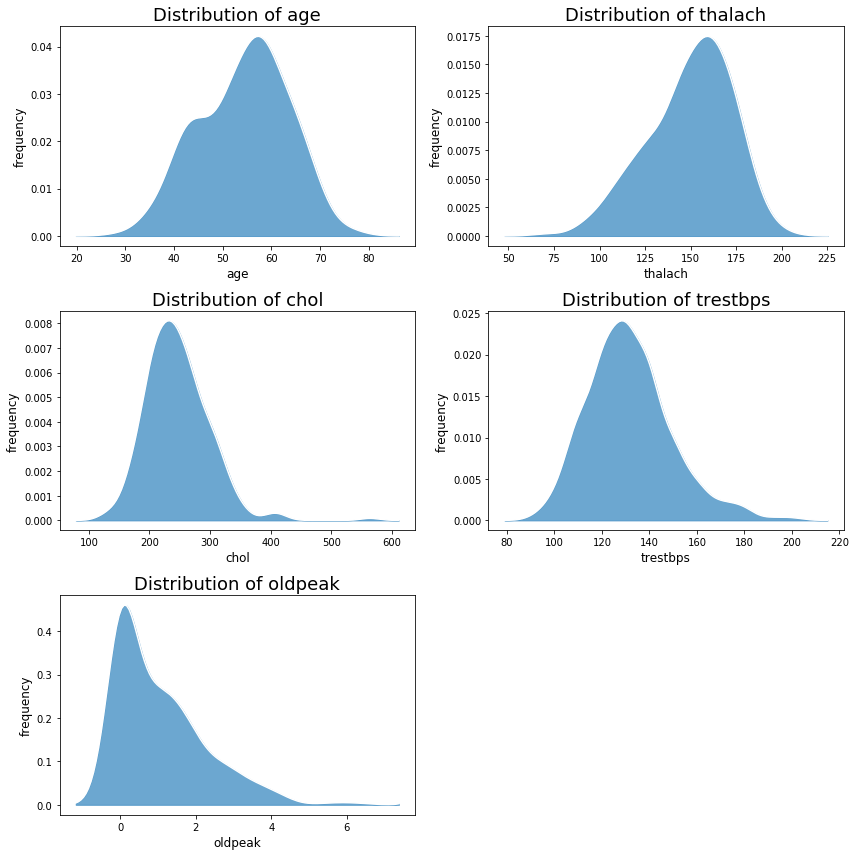

In [5]:
f,ax=plt.subplots(3,2,figsize=(12,12))
f.delaxes(ax[2,1])

numerical_features = ['age','thalach','chol','trestbps','oldpeak']

for i,feature in enumerate(numerical_features):
    sns.distplot(dataset[feature], ax=ax[i//2,i%2], kde_kws={"color":"white"}, hist=False )

    # Get the two lines from the ax[i//2,i%2]es to generate shading
    l1 = ax[i//2,i%2].lines[0]

    # Get the xy data from the lines so that we can shade
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    ax[i//2,i%2].fill_between(x1,y1, color="#4791C5", alpha=0.8)

    #grid
    #ax[i//2,i%2].grid(b=True, which='major', color='grey', linewidth=0.3)
    
    ax[i//2,i%2].set_title('Distribution of {}'.format(feature), fontsize=18)
    ax[i//2,i%2].set_ylabel('count', fontsize=12)
    ax[i//2,i%2].set_xlabel('Modality', fontsize=12)

    #sns.despine(ax[i//2,i%2]=ax[i//2,i%2], left=True)
    ax[i//2,i%2].set_ylabel("frequency", fontsize=12)
    ax[i//2,i%2].set_xlabel(str(feature), fontsize=12)
    
plt.tight_layout()
plt.show()


In [33]:
def create_distplot(type, data, col, visible=False):
    return go.Histogram(
        x = data[col],
        name = type, 
        visible = visible,
        opacity = PLOTLY_OPACITY,
    )

In [2]:
#numerical_features = ['age','thalach','chol','trestbps','oldpeak']
##hist_features = [col for col in dataset.columns if col in numerical_features]
#
#steps = []
#active_index = 0
#
#number_of_features = len(numerical_features)
#
#data = [(create_distplot(numerical_features[i], dataset[numerical_features[i]], col, False) if i!=active_index
#         else create_distplot(numerical_features[i], dataset[numerical_features[i]], col, True))
#        for i, col in zip(range(number_of_features), enumerate(numerical_features))]
#
#for i in range(number_of_features):
#    step = dict(
#        method = 'restyle',
#        args = ['visible', [False] * number_of_features],
#        label = numerical_features[i],
#    )
#    step['args'][1][i] = True
#    steps.append(step)
#    
#sliders = [dict(
#    active = active_index,
#    currentvalue = dict(
#        prefix = 'Feature: ',
#        xanchor = 'center',
#    ),
#    pad = {"t": 50},
#    steps = steps,
#    len = 1,
#)]
#    
#layout = dict(
#    sliders = sliders,
#    autosize = True,
#    yaxis = dict(
#        title = 'Frequency',
#        automargin = True,
#    ),
#    barmode = 'group',
#    bargap = 0.15,
#    bargroupgap = 0.1
#)
#    
#fig = dict(data=data, layout=layout)
#py.iplot(fig, filename='numerical_slider')

### DATI CATEGORICI

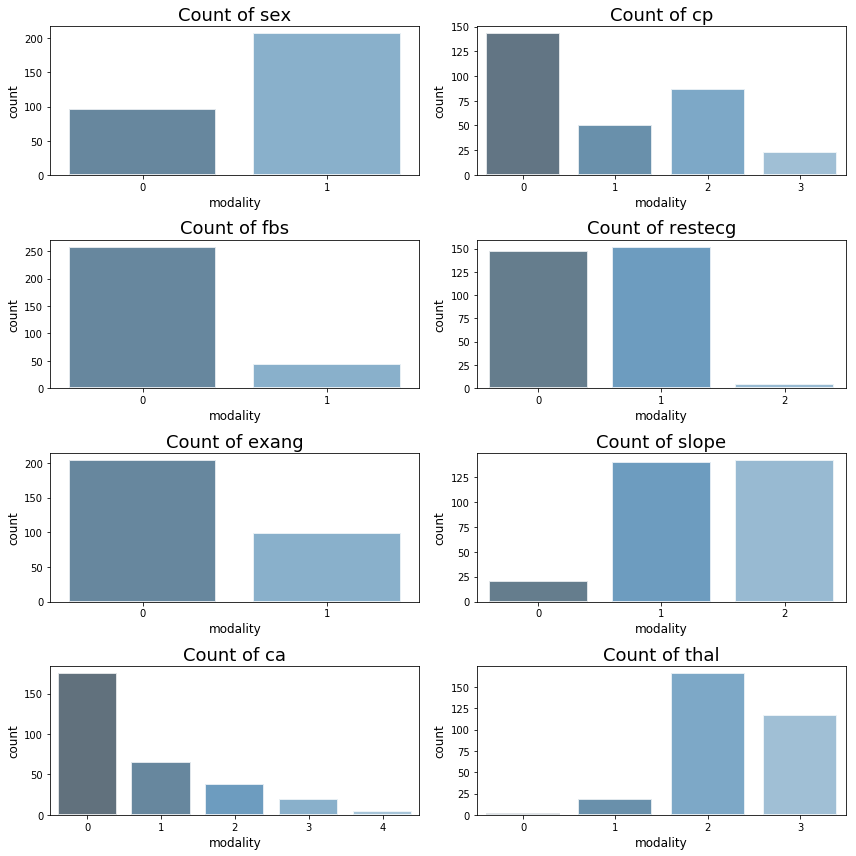

In [17]:
f,ax=plt.subplots(4,2,figsize=(12,12))

for i,feature in enumerate(['sex','cp','fbs','restecg','exang','slope','ca','thal']):
    sns.countplot(x=feature,data=dataset,ax=ax[i//2,i%2], palette = 'Blues_d', alpha=0.8, edgecolor=('white'), linewidth=2)
    ax[i//2,i%2].set_title('Count of {}'.format(feature), fontsize=18)
    ax[i//2,i%2].set_ylabel('count', fontsize=12)
    ax[i//2,i%2].set_xlabel('modality', fontsize=12)


plt.tight_layout()
plt.show()

### MACHINE LEARNING

In [ ]:
X = dataset.remove['target']
y = dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=5, stratify=y)

